<img src="https://i.imgur.com/6U6q5jQ.png"/>

# Analytics on GeodataFrames

This is time to use  local indicators (social, economic, physical, etc.)  at each spatial location to produce some analytics. Let's follow an approach based on a the amount of variables involved.

Let's create a repo in with GitHub. Put this [file](https://drive.google.com/file/d/1EYacndGCRiF1ZHEnGa-avTXSEtqB2e7p/view?usp=sharing) in the maps folder, and this other [file](https://docs.google.com/spreadsheets/d/1xpsz9n-SBTwgtXsugmabpBJ-tCaEwg9_/edit?usp=sharing&ouid=106935788518947165917&rtpof=true&sd=true) in the data folder. 

Let's read the data in:

In [1]:
# data table
import pandas as pd
import os

datadis=pd.read_excel(os.path.join('data','dataPeru_indicadores.xlsx'),
                     dtype={'Ubigeo': object})
datadis.head()

,Ubigeo,Departamento,Provincia,Distrito,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,010202,Amazonas,Bagua,ARAMANGO,10940,809.07,0.361182,37.545885,62.9,9.1
1,010201,Amazonas,Bagua,BAGUA,26091,150.99,0.584063,70.795501,25.4,0.7
2,010203,Amazonas,Bagua,COPALLIN,6319,99.05,0.467245,52.571361,45.4,2.1
3,010204,Amazonas,Bagua,EL PARCO,1492,18.48,0.489049,70.215409,59.9,1.5
4,010205,Amazonas,Bagua,IMAZA,24323,4430.84,0.298089,31.295719,88.4,11.7


In [2]:
# map
import geopandas as gpd

datadismap=gpd.read_file(os.path.join('maps','DistritosMap.zip'))

datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,INSTITUCIO,geometry
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,IGN,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1..."
1,TACNA,TACNA,POCOLLAY,IGN,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9..."
2,TACNA,TACNA,CALANA,IGN,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9..."
3,TACNA,TACNA,TACNA,IGN,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9..."
4,TACNA,TACNA,SAMA,IGN,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9..."


## Preprocessing

After observing both tables, it would be better if the columns with names have the same capitalization, and no extra blank spaces:

In [3]:
capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)

The names from non-english speaking countries may come with some symbols that may cause trouble (', ~). Let's get rid of those:

In [4]:
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].map(byePunctuation)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].map(byePunctuation)

Let me see how many district we have:

In [5]:
len(datadis.Distrito),len(datadismap.DISTRITO)

(1874, 1874)

Are the name of the districts unique?

In [6]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

(154, 152)

The presence of duplicates, forces we create  a column of unique values:

In [7]:
# concatenating
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [8]:
# the new column looks like this:
datadis['provDist'].head()

0    BAGUA+ARAMANGO
1       BAGUA+BAGUA
2    BAGUA+COPALLIN
3    BAGUA+EL PARCO
4       BAGUA+IMAZA
Name: provDist, dtype: object

It would be good making sure no *ghost* appears between words:

In [9]:
# replacing dashes and multiple spaces by a simple space
datadis.provDist=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap.provDist=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

## Merging

We need to merge both tables now. That can happen effectively if both tables have a **key** column: a column (or collection of them) whose values in one table are the same in the other one.

The match need not be exact, but only common values in the *key* are merged.

Let's find out what is NOT matched in each table:

In [10]:
nomatch_df=set(datadis.provDist)- set(datadismap.provDist)
nomatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

This is what could not be matched:

In [11]:
len(nomatch_df), len(nomatch_gdf)

(8, 8)

The datadis df does not have 26 values in its provDist column that match in the provDist column in datadismap gdf, the same count happens the way around. 

You can try renaming here row by row (or in the original file), but the right way to go is using **fuzzy merging**:

In [12]:
# pick the closest match from nomatch_gdf for a value in nomatch_df
from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('HUARAZ+PAMPAS', ('HUARAZ+PAMPAS GRANDE', 90)),
 ('LEONCIO PRADO+DANIEL ALOMIAS ROBLES',
  ('LEONCIO PRADO+DANIEL ALOMIA ROBLES', 99)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('PIURA+26 DE OCTUBRE', ('PIURA+VEINTISEIS DE OCTUBRE', 86)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

If you are comfortable, you prepare a _dictionary_ of changes:

In [13]:
# is this OK?
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'HUARAZ+PAMPAS': 'HUARAZ+PAMPAS GRANDE',
 'LEONCIO PRADO+DANIEL ALOMIAS ROBLES': 'LEONCIO PRADO+DANIEL ALOMIA ROBLES',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'PIURA+26 DE OCTUBRE': 'PIURA+VEINTISEIS DE OCTUBRE',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

In [14]:
# then:
changesDis_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

Now, make the replacements:

In [15]:
datadis.provDist.replace(changesDis_df,inplace=True)

Now the merge can happen:

In [16]:
datadismap=datadismap.merge(datadis, on='provDist')

In [17]:
# check
datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   INSTITUCIO                1874 non-null   object  
 4   geometry                  1874 non-null   geometry
 5   provDist                  1874 non-null   object  
 6   Ubigeo                    1874 non-null   object  
 7   Departamento              1874 non-null   object  
 8   Provincia                 1874 non-null   object  
 9   Distrito                  1874 non-null   object  
 10  Poblacion                 1874 non-null   int64   
 11  Superficie                1874 non-null   float64 
 12  IDH2019                   1874 non-null   float64 
 13  Educ_sec_comp2019_pct     1874 non-null 

We can get rid of some columns:

In [18]:
bye=['Departamento', 'Provincia', 'Distrito','INSTITUCIO','provDist']
datadismap.drop(columns=bye,inplace=True)

# keeping
datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",230110,123662,187.74,0.578968,71.178389,15.8,0.8
1,TACNA,TACNA,POCOLLAY,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...",230108,22319,265.65,0.645954,75.825743,16.1,0.9
2,TACNA,TACNA,CALANA,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...",230103,3338,108.38,0.564102,77.829717,15.9,3.3
3,TACNA,TACNA,TACNA,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...",230101,80845,1877.78,0.696613,75.491958,7.4,0.6
4,TACNA,TACNA,SAMA,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...",230109,2679,1115.98,0.552622,70.500250,52.4,10.8


We can save this gdf:

In [19]:
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

## Exploring one variable

This time, we explore statistically one variable:

This plot tells you the distribution of the values above for the last three columns:

array([[<Axes: title={'center': 'Educ_sec_comp2019_pct'}>,
        <Axes: title={'center': 'NBI2017_pct'}>],
       [<Axes: title={'center': 'Viv_sin_serv_hig2017_pct'}>, <Axes: >]],
      dtype=object)

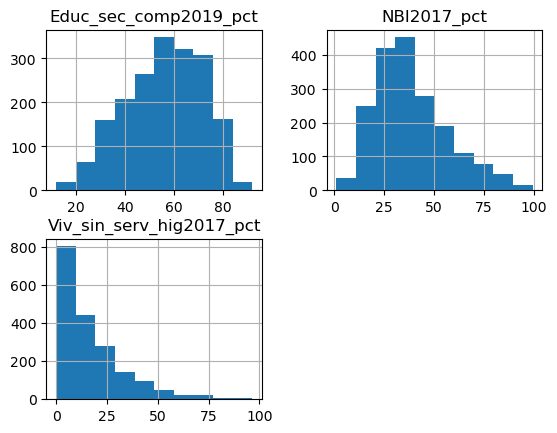

In [25]:
datadismap.select_dtypes(include=np.number).iloc[:,-3:].hist()

<Axes: >

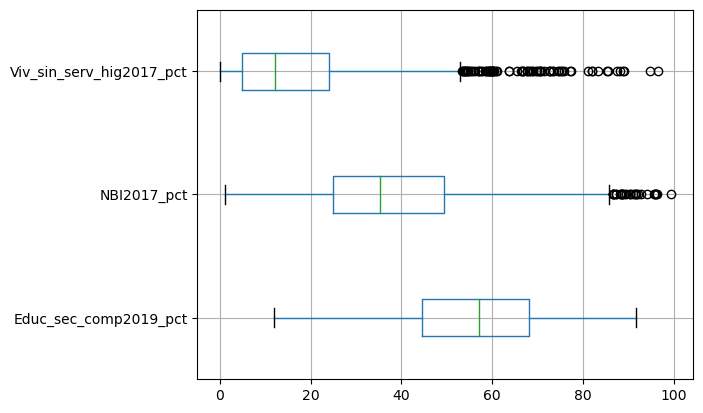

In [26]:
datadismap.select_dtypes(include=np.number).iloc[:,-3:].boxplot(vert=False)

In [128]:
# statistics
import numpy as np

datadismap.select_dtypes(include=np.number).iloc[:,-3:].describe() # only numeric

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1874.000000,1874.000000,1874.000000
mean,55.769523,38.593330,17.068783
std,15.728123,18.297153,16.354910
min,11.974433,1.100000,0.000000
25%,44.466678,24.900000,4.925000
50%,57.164771,35.300000,12.050000
75%,68.202230,49.275000,24.100000
max,91.744878,99.400000,96.500000


In [94]:
stats=datadismap.select_dtypes(include=np.number).iloc[:,-3:].describe() 

In [95]:
stats.index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [96]:
stats.loc['iqr',:]=stats.loc['75%']-stats.loc['25%']
stats

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1874.000000,1874.000000,1874.000000
mean,55.769523,38.593330,17.068783
std,15.728123,18.297153,16.354910
min,11.974433,1.100000,0.000000
25%,44.466678,24.900000,4.925000
50%,57.164771,35.300000,12.050000
75%,68.202230,49.275000,24.100000
max,91.744878,99.400000,96.500000
iqr,23.735552,24.375000,19.175000


In [116]:
stats.loc['topOut',:]=stats.loc['75%']+1.5*stats.loc['iqr']
stats.loc['bottomOut',:]=stats.loc['25%']-1.5*stats.loc['iqr']
stats.loc['xtopOut',:]=stats.loc['75%']+3*stats.loc['iqr']
stats.loc['xbottomOut',:]=stats.loc['25%']-3*stats.loc['iqr']

stats

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1874.0,1874.0,1874.0
mean,55.769523,38.59333,17.068783
std,15.728123,18.297153,16.35491
min,11.974433,1.1,0.0
25%,44.466678,24.9,4.925
50%,57.164771,35.3,12.05
75%,68.20223,49.275,24.1
max,91.744878,99.4,96.5
iqr,23.735552,24.375,19.175
topOut,103.805557,85.8375,52.8625


In [130]:
stats.loc[['xbottomOut','bottomOut','25%', '50%', '75%','topOut','xtopOut'],'Educ_sec_comp2019_pct']

xbottomOut    -26.739977
bottomOut        8.86335
25%            44.466678
50%            57.164771
75%             68.20223
topOut        103.805557
xtopOut       139.408884
Name: Educ_sec_comp2019_pct, dtype: object

In [126]:
detect(datadismap.Educ_sec_comp2019_pct)

55.7695232431989

In [69]:
from scipy.stats import iqr
stats.apply(lambda x: iqr(x))#,nan_policy='omit'))

Educ_sec_comp2019_pct       36.805852
NBI2017_pct                 38.556962
Viv_sin_serv_hig2017_pct    31.931250
dtype: float64

In [45]:
datadismap.select_dtypes(include=np.number).iloc[:,-3:].quantile([0.25,0.75])

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0.25,44.466678,24.900,4.925
0.75,68.202230,49.275,24.100


In [ ]:
# update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

### Exercise 2

<div class="alert-success">
    
1. Choose a numeric variable from your merged data.
2. Decide which are the three best classification schemes for that variable.
3. Make a map for each scheme selected.    
</div>

# Exploring several variables

We can turn our attention to several variables now:

In [131]:
selected_variables = ['Educ_sec_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']
datadismap[selected_variables].describe()

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1874.000000,1874.000000,1874.000000
mean,55.769523,38.593330,17.068783
std,15.728123,18.297153,16.354910
min,11.974433,1.100000,0.000000
25%,44.466678,24.900000,4.925000
50%,57.164771,35.300000,12.050000
75%,68.202230,49.275000,24.100000
max,91.744878,99.400000,96.500000


Visualization in a key procedure to detect the need for further data transformation:

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

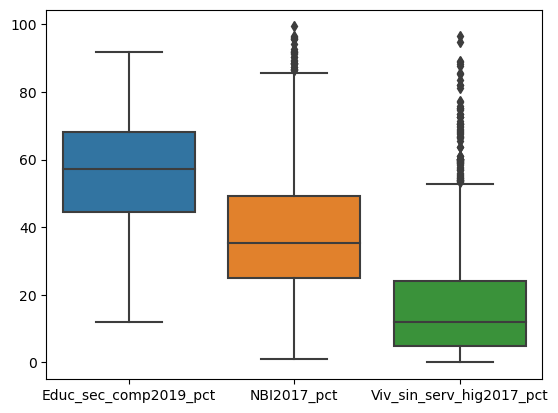

In [133]:
import seaborn as sea

sea.boxplot(datadismap[selected_variables])

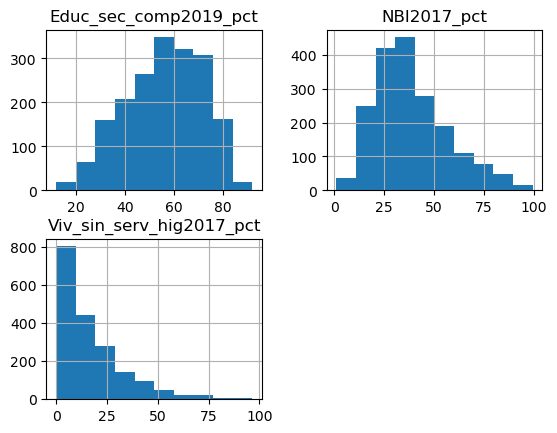

In [134]:
datadismap[selected_variables].hist();

Both univariate plots do not allow to see the relationships. Let's try a scatterplot:

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_

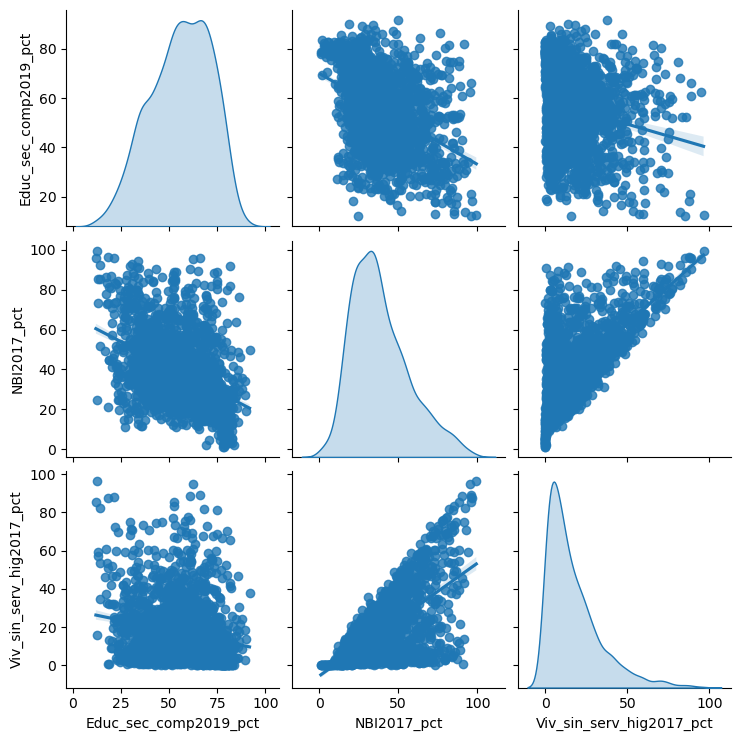

In [135]:
sea.pairplot(
    datadismap[selected_variables], kind="reg", diag_kind="kde"
)

We finally realize that **Educ_sec_comp2019_pct** has a negative correlation with the others (as expected). Let me reverse the variable:

<Axes: >

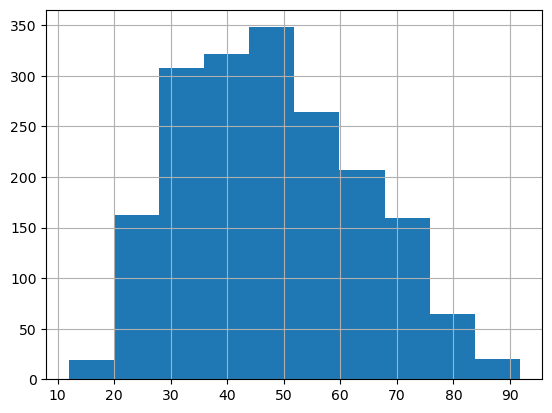

In [136]:
reverse=lambda x:abs(x-x.max())+x.min()

datadismap['Educ_sec_NO_comp2019_pct']=reverse(datadismap['Educ_sec_comp2019_pct'])
datadismap['Educ_sec_NO_comp2019_pct'].hist()

Now all our correlations will be positive:

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_

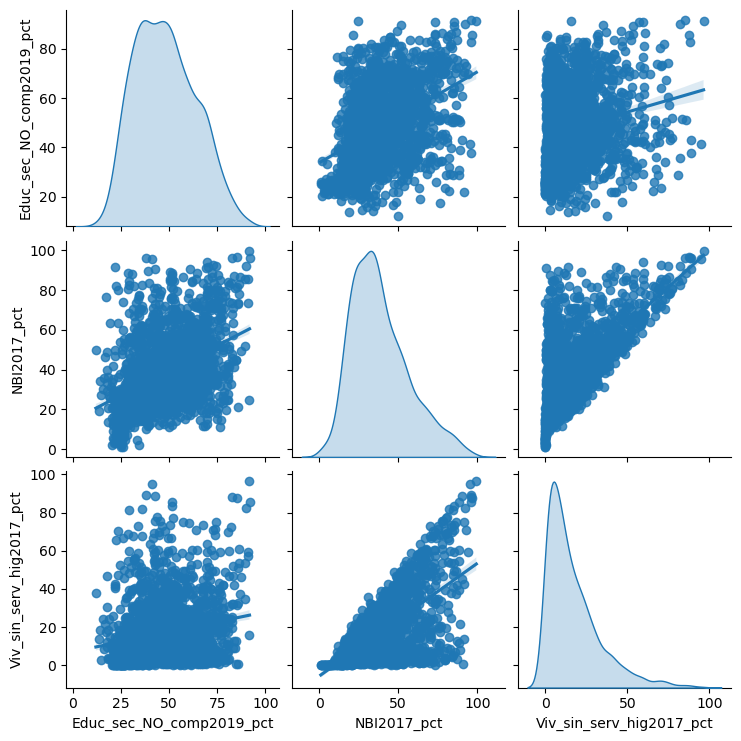

In [137]:
selected_variables_new = ['Educ_sec_NO_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']
sea.pairplot(
    datadismap[selected_variables_new], kind="reg", diag_kind="kde"
)

Keep in mind that the boxplot showed outliers. Let me try to re scale the data to smooth the distribution a little:

In [138]:
columnsToScale=selected_variables_new


from sklearn.preprocessing import robust_scale as rs
from sklearn.preprocessing import power_transform as pt
from sklearn.preprocessing import quantile_transform as qt

rs_result=rs(datadismap[columnsToScale])
pt_result=pt(datadismap[columnsToScale])
qt_result=qt(datadismap[columnsToScale])

Let's see the results:

<Axes: >

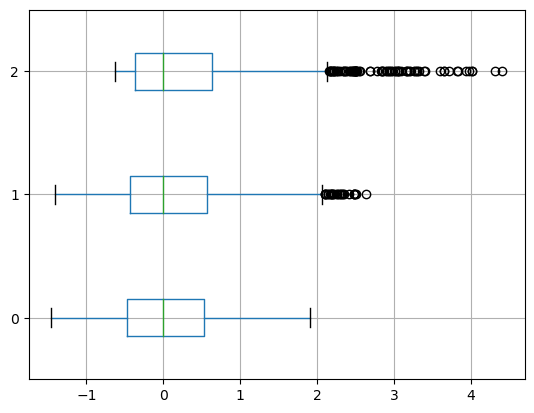

In [139]:
pd.DataFrame(rs_result).boxplot(vert=False)

<Axes: >

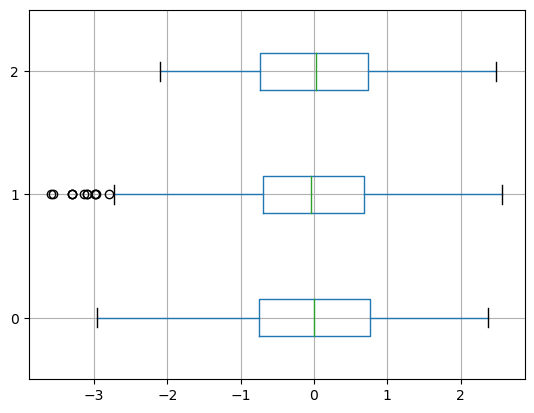

In [140]:
pd.DataFrame(pt_result).boxplot(vert=False)

<Axes: >

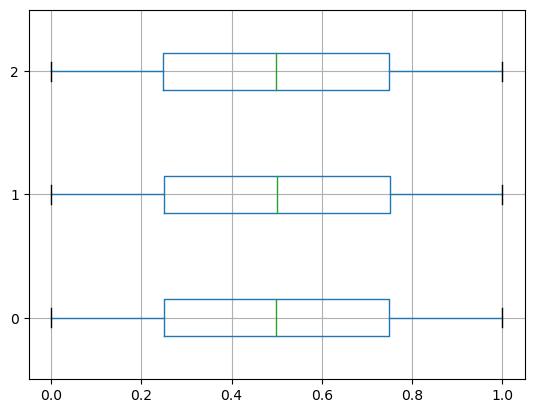

In [141]:
pd.DataFrame(qt_result).boxplot(vert=False)

I will keep the **qt_result**, so let me add some columns to the gdf:

In [142]:
# new names
selected_variables_new_t=[s+'_t' for s in selected_variables_new ]

# add colunms
datadismap[selected_variables_new_t]=qt_result

Let's plot the data we have used (I will the quantiles scheme **without** pre evaluation):

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/si

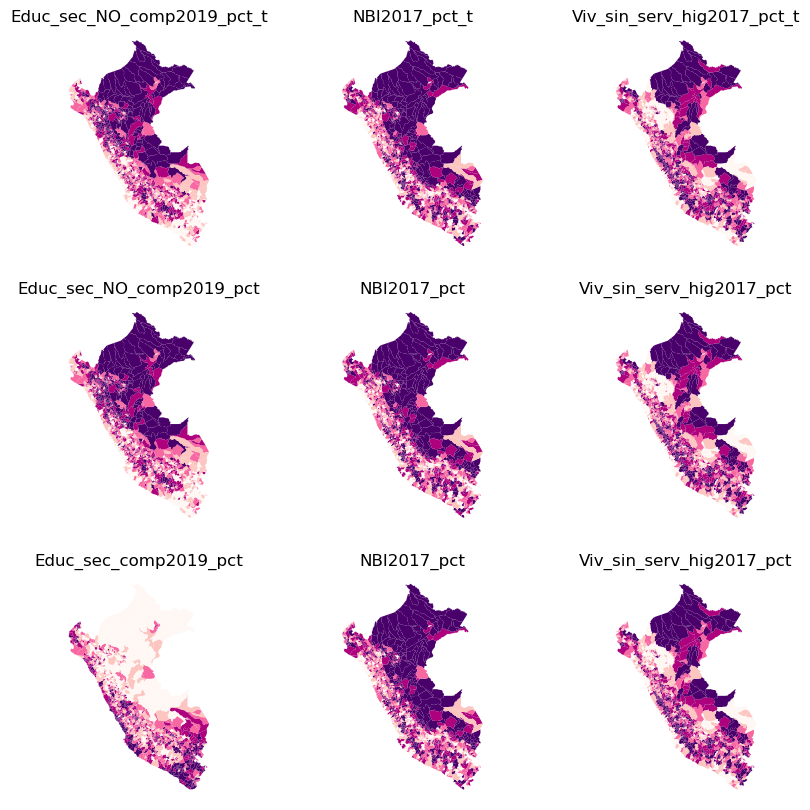

In [144]:
import matplotlib.pyplot as plt

f, axs = plt.subplots( ncols=3, nrows=3,figsize=(10, 10))
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(selected_variables_new_t + selected_variables_new + selected_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    datadismap.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [ ]:
# update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

### Exercise 3

<div class="alert-success">
    
1. Select three numeric variables.
    
2. Explore each one as above:
    * If needed reverse the variables (so that correlations are positive)
    * If needed re scale the variables (so that outliers are smoothed)
    * Evalue the  classification schemes for each variable.

4. Prepare a map for each variable, using the best classification scheme for each variable.


    
</div>

## Clustering

We used clustering to organize the data into homogeneus groups. Let me use a **dendogram** to explore the possible clusters:

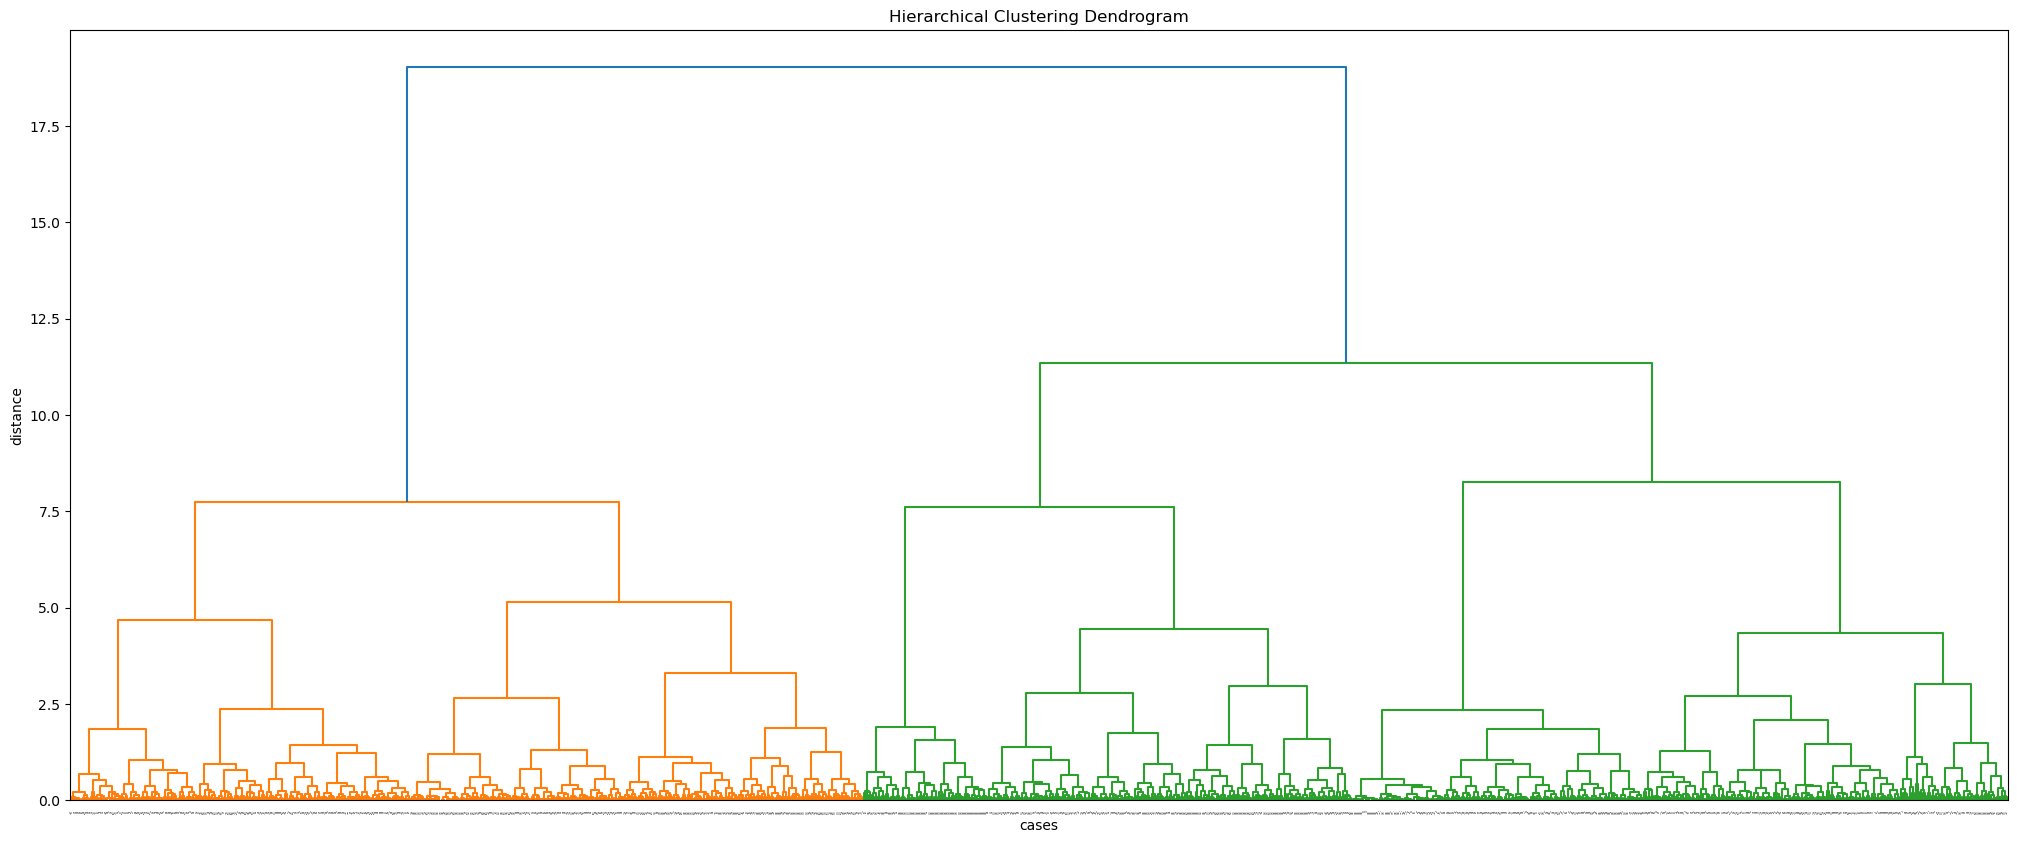

In [145]:
from scipy.cluster import hierarchy as hc


Z = hc.linkage(qt_result, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cases')
plt.ylabel('distance')
hc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1,  # font size for the x axis labels
)
plt.show()

I have used all the variables in the dendogram, so I can decide how many groups could be created using that data:

In [146]:
from sklearn.cluster import AgglomerativeClustering as agnes
# Set seed for reproducibility
np.random.seed(12345)
# Initialize the algorithm, requesting 3 clusters
model = agnes(linkage="ward", n_clusters=3).fit(datadismap[selected_variables_new_t])
# Assign labels to main data table
datadismap["hc_3"] = model.labels_

I reduce all the information from the three variables into a cluster variable:

In [147]:
datadismap["hc_3"].value_counts()

hc_3
1    767
0    635
2    472
Name: count, dtype: int64

Let's use the mean of each variable to understand the clusters:

In [148]:
datadismap.groupby("hc_3")[selected_variables_new].mean()

,Educ_sec_NO_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
hc_3,,,
0,32.829263,26.461732,8.322047
1,55.092692,51.354889,30.916688
2,56.684798,34.176907,6.333263


I could profile the clusters better if I prepare a plot with all the variables. Let me create a new data frame in long shape:

In [149]:
# Index db on cluster ID
datadismap_long = datadismap.set_index("hc_3").copy()
# Keep only variables used for clustering
datadismap_long = datadismap_long[selected_variables_new]
# Stack column names into a column, obtaining
# a "long" version of the dataset
datadismap_long = datadismap_long.stack()
# Take indices into proper columns
datadismap_long = datadismap_long.reset_index()
# Rename column names
datadismap_long = datadismap_long.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
datadismap_long.head()

,hc_3,Attribute,Values
0,0,Educ_sec_NO_comp2019_pct,32.540922
1,0,NBI2017_pct,15.800000
2,0,Viv_sin_serv_hig2017_pct,0.800000
3,0,Educ_sec_NO_comp2019_pct,27.893567
4,0,NBI2017_pct,16.100000


Nos the profiling:

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/seaborn/_

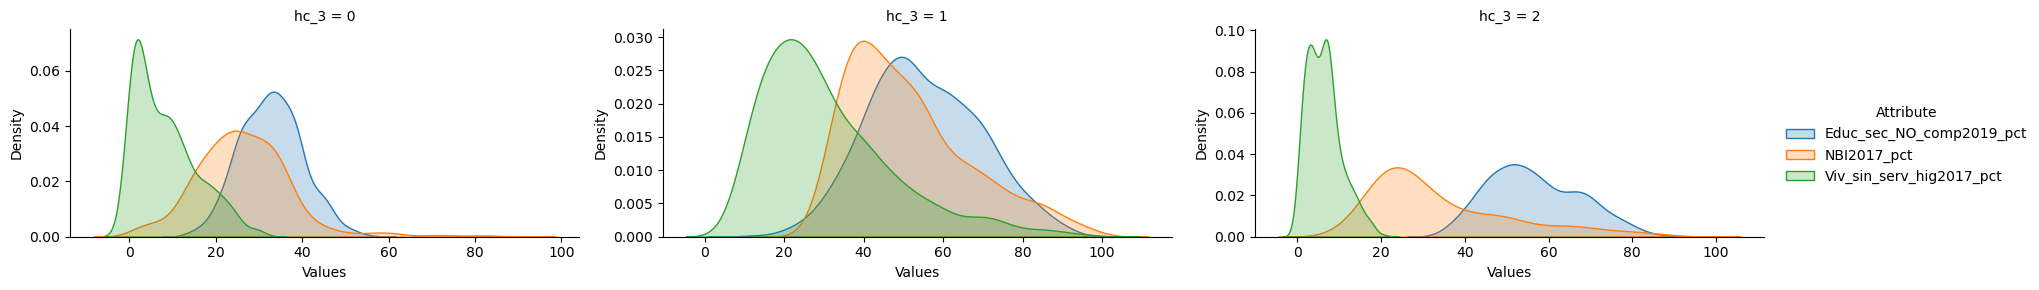

In [150]:
# Setup the facets
facets = sea.FacetGrid(
    data=datadismap_long,
    col="hc_3",
    hue="Attribute",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot as a `sns.kdeplot`
facets.map(sea.kdeplot, "Values", fill=True).add_legend()

Finally, just color the map:

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


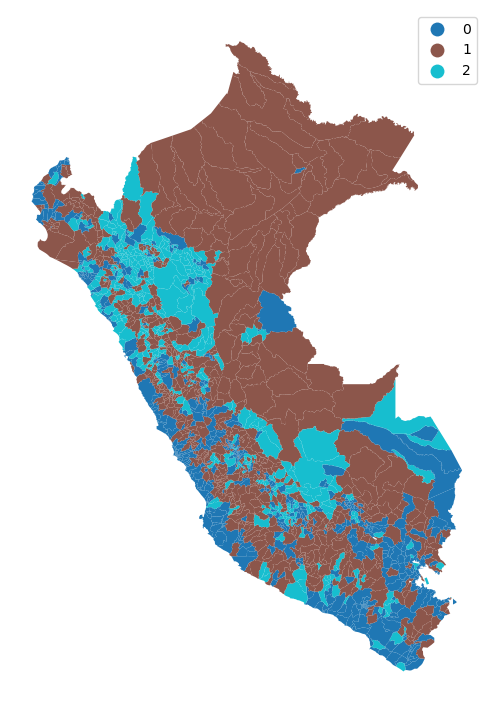

In [151]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
datadismap.plot(
    column="hc_3", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### Exercise 4

<div class="alert-success">
    
1. Keep the previous three variables, after you pre processed them.
    
2. Prepare a dendogram, and decide which is better: 3 or 5 clusters.
    
3. Cluster the data into the amount of clusters selected.

4. Prepare a visualization to profile each cluster.

5. Plot the cluster map.


    
</div>

## Spatial Correlation

### Neighboorhood

We can compute the neighborhood in a map using different algorithms:

In [153]:
from libpysal.weights import Queen, Rook, KNN

# rook
w_rook = Rook.from_dataframe(datadismap) 

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_13050/955072939.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook = Rook.from_dataframe(datadismap)
/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 89, 122.
  warnings.warn(message)


In [154]:
# rook
w_queen = Queen.from_dataframe(datadismap)

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_13050/1102841571.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = Queen.from_dataframe(datadismap)


In [155]:
# k nearest neighbors
w_knn = KNN.from_dataframe(datadismap, k=4)

Let's understand the differences:

In [156]:
# first one
datadismap.head(1)

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,Educ_sec_NO_comp2019_pct,Educ_sec_NO_comp2019_pct_t,NBI2017_pct_t,Viv_sin_serv_hig2017_pct_t,hc_3
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",230110,123662,187.74,0.578968,71.178389,15.8,0.8,32.540922,0.18121,0.061562,0.045546,0


In [184]:
# how manye neighbors of that district?
len(w_rook.neighbors[0] )

1

In [185]:
# details
datadismap.iloc[w_rook.neighbors[0],:]

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,Educ_sec_NO_comp2019_pct,Educ_sec_NO_comp2019_pct_t,NBI2017_pct_t,Viv_sin_serv_hig2017_pct_t,hc_3
3,TACNA,TACNA,TACNA,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...",230101,80845,1877.78,0.696613,75.491958,7.4,0.6,28.227352,0.102074,0.011551,0.035536,0


<Axes: >

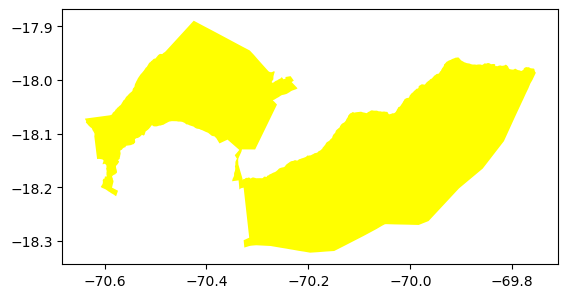

In [186]:
# see the neighbor
datadismap.iloc[w_rook.neighbors[0] ,].plot(facecolor="yellow")

In [190]:
# whole area
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_rook.neighbors[0] ,].plot(ax=base,facecolor="yellow")
datadisMap.head(1).plot(ax=base,facecolor="red")

NameError: name 'datadisMap' is not defined

Let's do the same:

In [189]:
# how many
len(w_queen.neighbors[0])

2

In [183]:
# details
datadisMap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="yellow")

[1, 3]

<Axes: >

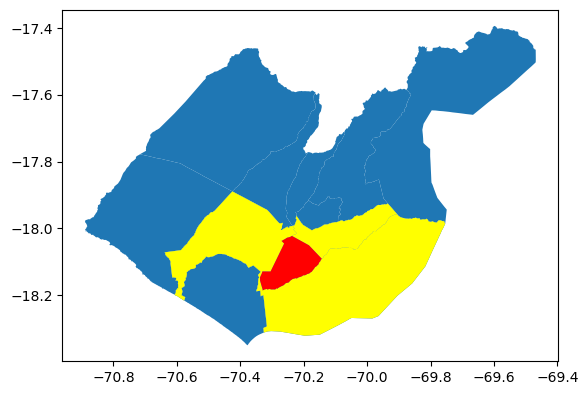

In [160]:
base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

In [161]:
w_knn.neighbors[0]

[3, 2, 1, 1806]

<Axes: >

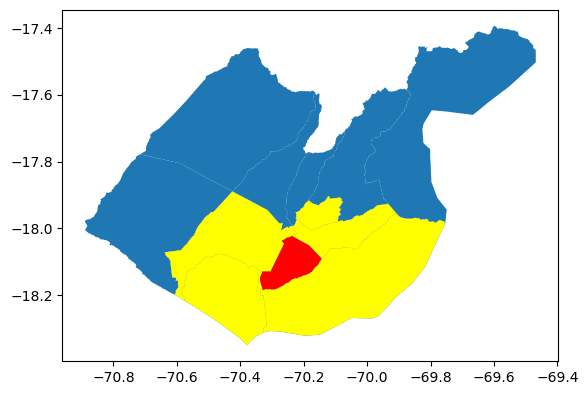

In [162]:

base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_knn.neighbors[0],].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

Let me pay attention to the knn results:

In [163]:
# all the neighbors by row
w_knn.neighbors

{0: [3, 2, 1, 1806],
 1: [2, 3, 5, 0],
 2: [1, 5, 3, 8],
 3: [0, 1, 2, 5],
 4: [6, 1806, 14, 13],
 5: [8, 2, 9, 1],
 6: [14, 7, 15, 4],
 7: [15, 6, 21, 14],
 8: [5, 2, 13, 9],
 9: [11, 5, 10, 2],
 10: [11, 17, 12, 9],
 11: [10, 12, 9, 17],
 12: [11, 24, 10, 19],
 13: [8, 17, 5, 18],
 14: [25, 6, 13, 4],
 15: [7, 21, 6, 36],
 16: [12, 11, 22, 9],
 17: [19, 10, 18, 20],
 18: [23, 20, 17, 19],
 19: [20, 17, 18, 23],
 20: [23, 18, 19, 29],
 21: [15, 7, 27, 36],
 22: [24, 12, 33, 16],
 23: [20, 18, 29, 31],
 24: [28, 12, 19, 22],
 25: [18, 23, 31, 14],
 26: [35, 36, 25, 31],
 27: [39, 30, 32, 21],
 28: [24, 19, 20, 34],
 29: [31, 23, 20, 34],
 30: [32, 41, 27, 39],
 31: [29, 23, 34, 20],
 32: [30, 41, 39, 27],
 33: [22, 38, 53, 24],
 34: [29, 31, 28, 23],
 35: [26, 37, 43, 45],
 36: [26, 21, 15, 35],
 37: [43, 45, 35, 74],
 38: [47, 33, 60, 53],
 39: [27, 30, 41, 32],
 40: [41, 73, 48, 32],
 41: [32, 30, 71, 39],
 42: [55, 57, 51, 39],
 43: [37, 45, 82, 74],
 44: [46, 50, 77, 83],
 45: [52,

In [164]:
# the matrix of neighboorhood:

pd.DataFrame(*w_knn.full()).astype(int) # 1 means both are neighbors

,0,1,2,3,4,5,6,7,8,9,...,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873
0,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
# count of zeros
w_knn.nonzero

7496

In [166]:
# pct of neighboorhood (density)
w_knn.pct_nonzero

0.21344717182497333

In [167]:
# a district with NO neighbor?
w_knn.islands

[]

### Exercise 5

<div class="alert-success">
    
1. Compute the three neighboohoods shown above for you data.
    
2. Select one polygon, and plot it with its neighbors as above.
    
</div>

## Spatial correlation

We need the neighboorhood matrix (the weight matrix) to compute spatial correlation: if the variable value is correlated with the values of its neighbors - which proves a spatial effect.

In [168]:
# needed for spatial correlation
w_knn.transform = 'R'

Spatial correlation is measured by the Moran's I statistic:

In [170]:
from esda.moran import Moran

moranIDH = Moran(datadismap['IDH2019'], w_knn)
moranIDH.I,moranIDH.p_sim

(0.6837588552721255, 0.001)

A significant Moran's I suggest spatial correlation. Let's see the spatial scatter plot

In [171]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranIDH, aspect_equal=True)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std')
plt.show()

ModuleNotFoundError: No module named 'splot'

### Exercise 6

<div class="alert-success">
    
1. Compute the Moran's coefficient for **all** your numeric variables.
    
2. Make a scatter plot for each variable.
    
</div>

### Local Spatial Correlation

We can compute a LISA (local Moran) for each case. That will help us find spatial clusters (spots) and spatial outliers:

* A **hotSpot** is a polygon whose value in the variable is high AND is surrounded with polygons with also high values.

* A **coldSpot** is a polygon whose value in the variable is low AND is surrounded with polygons with also low values.

* A **coldOutlier** is a polygon whose value in the variable is low BUT is surrounded with polygons with  high values.

* A **hotOutlier** is a polygon whose value in the variable is high BUT is surrounded with polygons with  low values.

It is also possible that no significant correlation is detected. Let's see those values:

In [ ]:
# The scatterplot with local info
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisaIDH = Moran_Local(y=datadismap['IDH2019'], w=w_knn,seed=2022)
fig, ax = moran_scatterplot(lisaIDH,p=0.05)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std')
plt.show()

In [ ]:
# the map with the spots and outliers

from splot.esda import lisa_cluster
f, ax = plt.subplots(1, figsize=(12, 12))
plt.title('Spots and Outliers')
fig = lisa_cluster(lisaIDH, 
                   datadismap,ax=ax,
                   legend_kwds={'loc': 'center left', 
                                'bbox_to_anchor': (0.7, 0.6)})
plt.show()

Let me add that data to my gdf:

In [ ]:
# quadrant
lisaIDH.q

In [ ]:
# significance
lisaIDH.p_sim

In [ ]:
# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
pd.Series(lisaIDH.q).value_counts()

The info in **lisaIDH.q** can not be used right away, we need to add if the local spatial correlation is significant:

In [ ]:
datadismap['IDH_quadrant']=[l if p <0.05 else 0 for l,p in zip(lisaIDH.q,lisaIDH.p_sim)  ]
datadismap['IDH_quadrant'].value_counts()

Now, we recode:

In [ ]:
labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

datadismap['IDH_quadrant_names']=[labels[i] for i in datadismap['IDH_quadrant']]

datadismap['IDH_quadrant_names'].value_counts()
                                  

Let's replot:

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3790, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'IDH_quadrant_names'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var

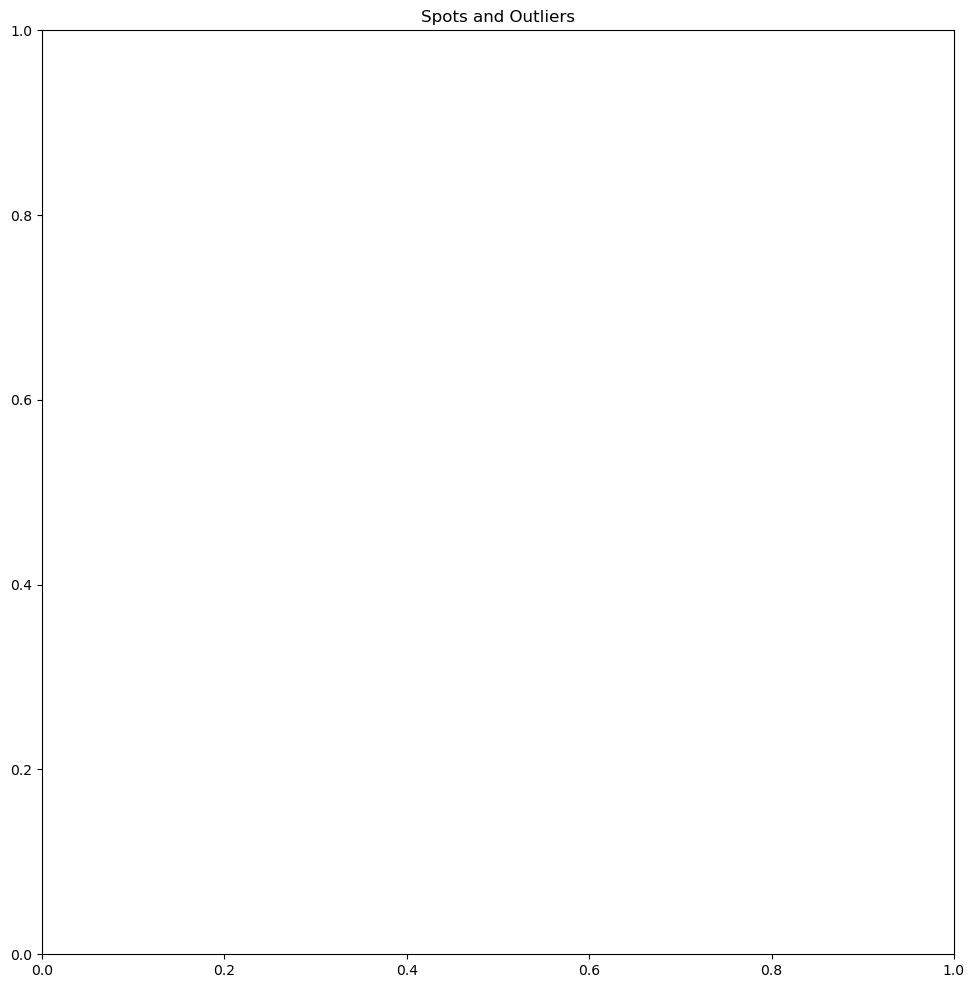

In [191]:
from matplotlib import colors
myColMap = colors.ListedColormap([ 'ghostwhite', 'red', 'green', 'yellow','orange'])



# Set up figure and ax
f, ax = plt.subplots(1, figsize=(12,12))
# Plot unique values choropleth including
# a legend and with no boundary lines

plt.title('Spots and Outliers')

datadismap.plot(column='IDH_quadrant_names', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='white',
                legend=True,
                legend_kwds={'loc': 'center left', 
                             'bbox_to_anchor': (0.7, 0.6)},
                ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [ ]:
# final update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

### Exercise 7

<div class="alert-success">
    
1. Compute the Local Moran for the variables in your data that have significant spatial correlation.
    
2. Create a new column for each of those variables, with a label ('0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier').

3. Prepare a map for each of the variables analyzed, showing the spots and outliers.
    
</div>